# 3. Basic Comparisons of Editions

In [2]:
import csv_utils
import pandas
from pprint import pprint
%matplotlib inline

A_data = csv_utils.load_csv('A_data.csv')
B_data = csv_utils.load_csv('B_data.csv')
C_data = csv_utils.load_csv('C_data.csv')

all_data = [A_data, B_data, C_data]

Loading the csv data into individual lists of DataFrames. I create all_data to contain them here because it is handy to iterate through that so I don't have to write the same code three times later.

### Game Length

,A,B,C
count,1000.000000,1000.000000,1000.000000
mean,38.240000,50.150000,27.859000
std,24.188623,41.877742,13.251291
min,7.000000,8.000000,8.000000
25%,21.000000,21.000000,19.000000
50%,32.000000,38.000000,25.000000
75%,49.000000,66.000000,34.000000
max,222.000000,338.000000,114.000000


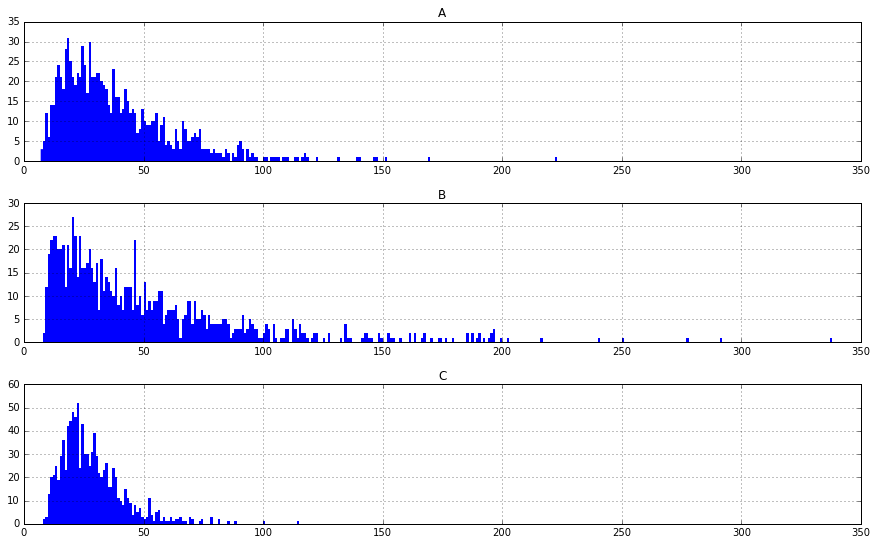

In [77]:
def make_measure(func, data_set):
    A_df = pandas.DataFrame({'A' : [func(run) for run in data_set[0]]})
    B_df = pandas.DataFrame({'B' : [func(run) for run in data_set[1]]})
    C_df = pandas.DataFrame({'C' : [func(run) for run in data_set[2]]})
    df = A_df.join(B_df.join(C_df))
    return df 

length_df = make_measure(len, all_data)

def get_max(data):
    return (max(max(data['A']),max(data['B']),max(data['C'])))

def get_min(data):
    return (min(min(data['A']),min(data['B']),min(data['C'])))

def make_histos(df):
    return df.hist(bins=range(get_min(df), get_max(df)+1), layout=(3,1), figsize=(15,9), edgecolor='none')

length_histo = make_histos(length_df)
length_df.describe()

Here we can clearly see a striking difference between my custom board and the others. The Milton-Bradley has an average game length of roughly 38 moves, and the online copy has an average game length of 50 moves, while mine only lasts 28 moves on average. Moreover, both of the premade games have a long tail, leading to a higher standard deviation, with both of them having a SD of over 50% of the mean. In contrast, my custom game with spread out, shorter snakes and ladders lead to a more consistent gamelength, with a standard deviation of only 13 and a much shorter tail.

### Spaces jumped

This measure refers to how many spaces were moved through usage of a snake or ladder. A setup with longer or more links will have a higher average spaces jumped. In games with higher spaces jumped, the links will have had a stronger influence over the game.

,A,B,C
count,1000.00000,1000.000000,1000.000000
mean,191.97600,318.546000,91.276000
std,155.10529,304.538733,64.939179
min,0.00000,0.000000,0.000000
25%,77.00000,105.000000,48.000000
50%,148.00000,229.500000,71.000000
75%,258.25000,433.000000,120.000000
max,1172.00000,2170.000000,496.000000


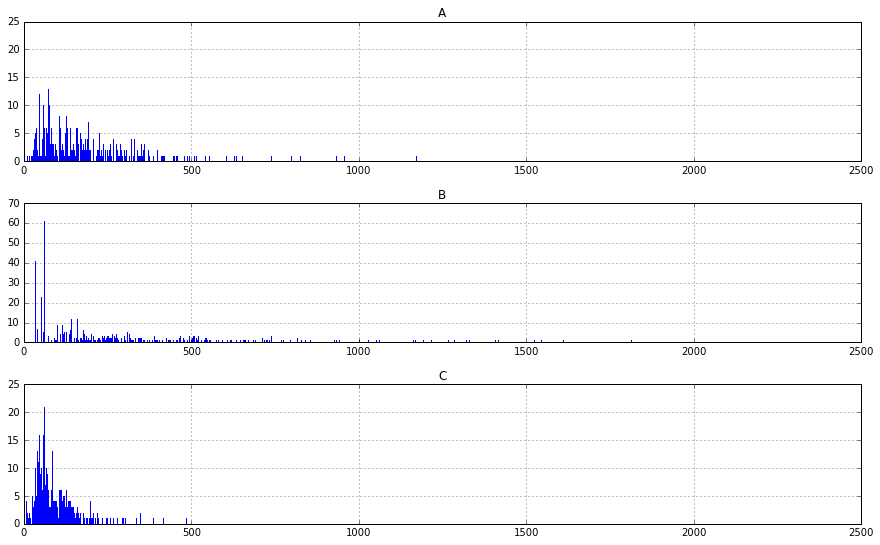

In [6]:
def count_skip(run):
    skip = 0
    for i in range(len(run)):
        if run['kind'][i] != 'B':
            skip = skip + abs(run['end'][i]-run['start'][i]-run['die'][i])
    return skip

skip_df = make_measure(count_skip, all_data)

skip_histos = make_histos(skip_df)
skip_df.describe()

Spaces jumped is ultimately a measure of the level of influence of snakes and ladders on the game. The online copy is the most extreme board here too, with its many and long snakes having a strong effect on the game, producing a mean of 318. However, it has a very high standard deviation (304), and indeed, the histogram illustrates how inconsistent this is with the nearly flat downward slope of frequency of skip amounts. This indicates that the length of the links may be having a stronger impact than the number of them, as a large number of short links would result in a lower standard deviation and a fairly short tail. This is exemplified by my custom board, which has just as many links as the online copy, but they tend to be much shorter. As you can see, it has a much shorter tail, peaking early and then decreasing quickly.

### Diversity

Diversity is the measure of how many different squares were landed on in a given game. A 100 diversity game run would include the player landing on every space at least once.

[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000014D29BA8>]


,A,B,C
count,1000.000000,1000.000000,1000.000000
mean,34.636000,36.186000,29.089000
std,14.196868,16.130269,10.109762
min,9.000000,9.000000,11.000000
25%,23.000000,23.000000,22.000000
50%,33.000000,35.000000,28.000000
75%,45.000000,48.000000,35.000000
max,81.000000,84.000000,78.000000


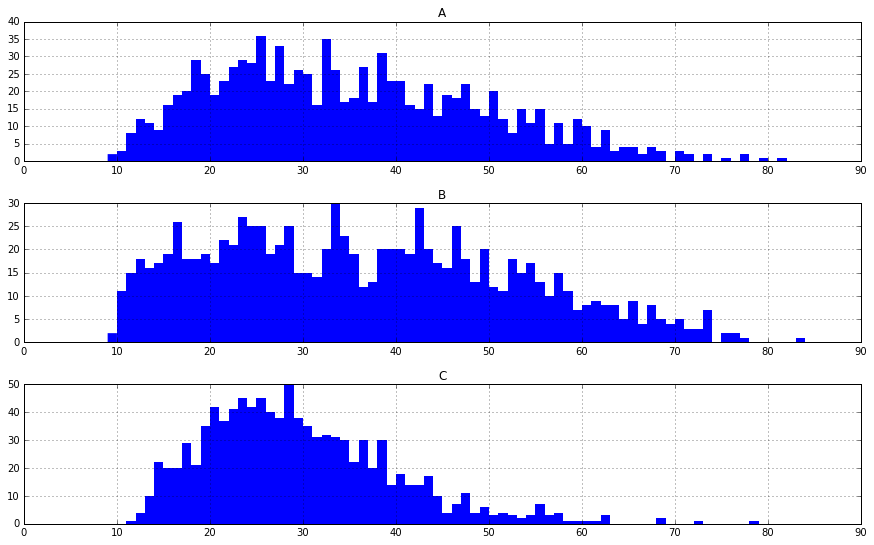

In [80]:
def count_diversity(run):
    traveled = [0] * 101
    for i in range(len(run)):
        traveled[run['end'][i]] = 1
        if (run['start'][i]+run['die'][i] <= 100):
            traveled[run['start'][i]+run['die'][i]] = 1
    return sum(traveled)

diversity_df = make_measure(count_diversity, all_data)
diversity_histo = make_histos(diversity_df)
print(diversity_histo)
diversity_df.describe()

Both boards A and B had a wider and greater spread of diversities due to their level of snakes, which encourage diversity by allowing the player to travel to squares they had already passed. Ladders do the opposite, so it makes sense that board C has a shorter tail and a lower mean.

# 4. Define "Loopiness" of a Game

### 4.1

In [26]:
import json
# Counts the number of times a specific snake/ladder was used in ONE game
def count_use(df, start):
    count = 0
    for i in range(len(df)):
        if (int(df['start'][i]) + int(df['die'][i])) == start:
            count += 1
    return count

setups = json.load(open('setups.json', 'r'))
A_starts = [snake[0] for snake in setups[0]['snakes']]
B_starts = [snake[0] for snake in setups[1]['snakes']]
C_starts = [snake[0] for snake in setups[2]['snakes']]


Here's my count_use function, which takes in a DataFrame that represents a run of the game and a start of a link (that I assume is a snake, but it doesn't actually matter to the function. It really just counts the number of times you land on a square) and outputs how many times that start was landed on.

After that, I create three lists just containing the starts of the snakes of each setup. This is easier to iterate through than the snakes themself. I reference my earlier created setups.json file to do this. The next step takes a bit of explanation, so I would recommend reading the markdown below it first.

### 4.2

In [27]:
starts_set = [A_starts, B_starts, C_starts]
A_recurrence = []
B_recurrence = []
C_recurrence = []

recurrences = [A_recurrence, B_recurrence, C_recurrence]
for i in range(3):
    for run in range(len(all_data[i])):
        run_recurrences = {}
        if (run % 100 == 0):
            print("{0}% complete with board {1}".format(run/10, i+1))
        for start in starts_set[i]:
            run_recurrences[start] = (count_use(all_data[i][run], start))
        recurrences[i].append(run_recurrences)

A_recurrence_df = pandas.DataFrame(A_recurrence)
B_recurrence_df = pandas.DataFrame(B_recurrence)
C_recurrence_df = pandas.DataFrame(C_recurrence)

print(A_recurrence_df)

0.0% complete with board 1
10.0% complete with board 1
20.0% complete with board 1
30.0% complete with board 1
40.0% complete with board 1
50.0% complete with board 1
60.0% complete with board 1
70.0% complete with board 1
80.0% complete with board 1
90.0% complete with board 1
0.0% complete with board 2
10.0% complete with board 2
20.0% complete with board 2
30.0% complete with board 2
40.0% complete with board 2
50.0% complete with board 2
60.0% complete with board 2
70.0% complete with board 2
80.0% complete with board 2
90.0% complete with board 2
0.0% complete with board 3
10.0% complete with board 3
20.0% complete with board 3
30.0% complete with board 3
40.0% complete with board 3
50.0% complete with board 3
60.0% complete with board 3
70.0% complete with board 3
80.0% complete with board 3
90.0% complete with board 3
     16  47  49  56  62  64  87  93  95  98
0     0   0   0   0   0   1   0   0   0   0
1     0   0   0   0   0   1   0   0   0   0
2     1   0   2   0   0   0   0

And here it is, the recurrence data.

This was an interesting problem, that took me a while to solve for a couple of reasons. I didn't get your email about precisely which data you wanted until the last day I had to work on it, and so I collected my data in a roundabout way: I collected as detailed data as I possibly could, which could then be collapsed and simplified into either of the two forms I emailed you about.

So in this step, I create a DataFrame for each setup that corresponds every single snake on it with how many times it triggered in each run. This is plainly far more detailed data than I need to measure loopiness, so I simplify it in the next step, but I was worried about you wanting the other form, so I collected it in this broad form first.

Another point to note about this step is that I didn't create a general function that takes in game records and outputs recurrence data. Instead, I simply created code that produced the recurrence data for the boards and data that I already had. This was a conscious choice on my part, as the question did not say I had to create a function, but merely create code that collected the data. So, it was easier to simply produce specific code rather than a general function. However, I would pay for this in time, during problem 6 when I have to get recurrence data for other boards and thus have to basically recreate my code. If I was doing a similar project in the future, I probably would code the data collection as a general function to begin with.

Also, the program takes ages to run, and I was worried about not being able to tell if it will ever stop, so I added progress reports.

In [28]:
#A_recurrence_averages = pandas.Series(sum/len(A_starts) for average in )

total_recurrence_df = pandas.DataFrame({'A' : A_recurrence_df.sum(axis=1), 'B' : B_recurrence_df.sum(axis = 1), 'C' : C_recurrence_df.sum(axis = 1)})
print(total_recurrence_df)



      A   B   C
0     1   2   1
1     1   6   1
2     4   5   2
3     1   0   0
4    10   5   0
5     7   4   3
6     4  11   5
7     4   4   0
8     1   2   3
9     5   6   0
10    2   9   3
11    0   3   2
12    2   2   1
13    1   5   1
14    2   5   7
15    6   2   2
16   13  16   4
17    3   3   8
18    5   4   7
19   18   8   2
20    3   1   3
21    6   1   1
22    3  12   4
23    3   0   3
24    3   3   3
25    3   2   2
26   12   5   8
27    4   6   3
28   10   3   0
29    5   2   3
..   ..  ..  ..
970   7   5   8
971   4   2   1
972  14   2   7
973  12   5   5
974   1   3   0
975   3   0   3
976   1   0   1
977   3   3   1
978   5   0   0
979   1   2   4
980   4   5   0
981   1   3   6
982   2   0   0
983   2   3  13
984   3   0   7
985   1   2   2
986   3   0   1
987   0   0   0
988   1   2   1
989   5   4   3
990   3   2   5
991   5   4   4
992   1   7   1
993   5   0   1
994   1   1   2
995   4   1   3
996   0   0   6
997   7   4   6
998  19   0   5
999   1   6   0

[1000 r

Here I transform my raw recurrence data into the loopiness metric you wanted.

In [29]:
print(total_recurrence_df.describe())

                 A            B            C
count  1000.000000  1000.000000  1000.000000
mean      4.221000     4.439000     2.864000
std       3.783976     5.015519     2.536126
min       0.000000     0.000000     0.000000
25%       1.000000     1.000000     1.000000
50%       3.000000     3.000000     2.000000
75%       6.000000     6.000000     4.000000
max      30.000000    33.000000    18.000000


Setup A and setup B have very similar average recurrences, 4.2 and 4.4 respectively. They both have more snakes than ladders and have fairly large snakes, so it makes sense that they have similar loopiness. However, even though it has just as many snakes my custom board, C, has a much lower loopiness of 2.86. This is most likely due to the higher number of ladders (10, the same as the amount of snakes) and the fact that the snakes that exist are shorter, and thus less likely to extend the game.

# 5. Another Measure of Recurrent Behavior

### 5.1

In [48]:
def detect_2_cycles(setup):
    link = []
    cycles = 0
    for i in range(setup['size']+1):
        link.append(i)
    link[100] = 101
    snakes = setup['snakes']
    for snake in snakes:
        link[snake[0]] = snake[1]
    ladders = setup['ladders']
    for ladder in ladders:
        link[ladder[0]] = ladder[1]
    for ladder in ladders:
        step = ladder[1]
        while not (link[step] > step):
            if link[step] < ladder[0]:
                jump_before = False
                for second_step in range(link[step], ladder[0]):
                    if link[second_step] != second_step:
                        jump_before = True
                if jump_before == False:
                    cycles += 1
                    break
                else:
                    break
            else:
                step += 1
    return cycles
        
for i in ['A', 'B', 'C']:
    print(i, detect_2_cycles(setups[['A', 'B', 'C'].index(i)]))
    


A 1
B 1
C 1


This is the 2_cycles metric. The function takes in the setup and outputs the number of 2-cycles contained within. 2-cycles are a pair of ladder and snake where the ladder is contained within the snake, but with one special condition: there can be no other snakes or ladders between the exit of the ladder and the entrance of the snake, and the exit of the snake and the entrance of the ladder.

My function finds this by first creating a list that contains the destination of all squares (the destination of a blank square is itself). Then, I iterate through the ladders, checking each square after its exit for its type. If it detects a snake before it detects a ladder, it looks through each step after that snakes exit through to the start of the ladder. If there are no snakes or ladders there, then it has found a 2-cycle and it increments my cycle count.

Interestingly, each setup only has one 2-cycle. With the Milton Bradley (A) and online (B) board, this is probably for playability reasons. Doing the same path multiple times would just get boring. For my custom board (C), this is a consequence of the fact that the link lengths are shorter, in general, and there is a ladder and a snake on every row (of the imaginary 10x10 board), so the links are spread out and it is difficult to find a snake that encloses a ladder without another between them.

# 6. Game Variations

# 6.1

In [56]:
from pprint import pprint
import copy
#reusing your setup validation code
def validate_setup(d):
    """
    Validate keys and top-level types of values for game setup dictionary, raising a
      KeyError or TypeError if invalid, otherwise silent.
    Does not distinguish list or tuple types of snakes/ladders pairs.
    Does not check other data constraints, such as snakes or ladder pair values being
      not equal or clashing with another pair's values.
    """
    keys = sorted(d.keys())
    need_keys = sorted(['size', 'snakes', 'ladders', 'diesides', 'name', 'URL'])
    if keys != need_keys:
        raise KeyError("Correct keys not present in setup dictionary")
    if not isinstance(d['size'], int):
        raise TypeError("'size' must be int")
    if not isinstance(d['diesides'], int):
        raise TypeError("'diesides' must be int")
    active = [False]*101 # my code! used to make sure there is only one link per tile
    for kind in ('snakes', 'ladders'):
        if isinstance(d[kind], (list, tuple)):
            try:
                for i1, i2 in d[kind]:
                    if active[i1] or active[i2]: #raises an error when there's more than one link per square
                        raise TypeError("Maximum of one link per square")
                    active[i1]=True # mine. records that this square has a link
                    active[i2]=True # mine. same as above
                    # this loop is agnostic about type of sequence
                    if not isinstance(i1+i2, int):
                        raise TypeError("'{}' must be a sequence of pairs of ints".format(kind))
            except ValueError:
                # too many or not enough values to unpack from d['snakes']
                raise TypeError("'{}' must be a sequence of pairs of ints".format(kind))
        else:
            raise TypeError("'{}' must be a sequence of pairs of ints".format(kind))
    return True

# Takes in a board, and returns a dict of setups with one link between 35 and 36 varied from -5 to +5 in start. The key is how they are varied.
def vary_game(setup):
    chosen_snake = (0,0)
    for snake in setup['snakes']:
        if snake[0] > 35 and snake[0] < 65:
            chosen_snake = snake
            break
    new_games = []
    for adjust in range(-5,6):
            new_game = copy.deepcopy(setup)
            new_game['snakes'].remove(chosen_snake)
            new_game['snakes'].append([chosen_snake[0]+adjust,chosen_snake[1]])
            new_game['name'] = [new_game['name'] + ' + {}'.format(adjust)]
            try:
                validate_setup(new_game)
                new_games.append(new_game)
            except TypeError:
                pass
    return new_games

vary_game(setups[1])



[{'URL': 'http://2.bp.blogspot.com/-BAXe2vGFAEo/UxFsY8PwCAI/AAAAAAAAE0c/uHRwHjY8lwk/s1600/Snakes&Ladders-Nationalseriesgames.jpg',
  'diesides': 6,
  'ladders': [[8, 26],
   [21, 82],
   [43, 77],
   [50, 91],
   [54, 93],
   [66, 87],
   [62, 96],
   [60, 100]],
  'name': ['Random online example + -5'],
  'size': 100,
  'snakes': [[73, 1],
   [55, 7],
   [48, 9],
   [59, 17],
   [83, 19],
   [44, 22],
   [95, 24],
   [98, 28],
   [69, 33],
   [64, 36],
   [92, 51],
   [41, 5]]},
 {'URL': 'http://2.bp.blogspot.com/-BAXe2vGFAEo/UxFsY8PwCAI/AAAAAAAAE0c/uHRwHjY8lwk/s1600/Snakes&Ladders-Nationalseriesgames.jpg',
  'diesides': 6,
  'ladders': [[8, 26],
   [21, 82],
   [43, 77],
   [50, 91],
   [54, 93],
   [66, 87],
   [62, 96],
   [60, 100]],
  'name': ['Random online example + -4'],
  'size': 100,
  'snakes': [[73, 1],
   [55, 7],
   [48, 9],
   [59, 17],
   [83, 19],
   [44, 22],
   [95, 24],
   [98, 28],
   [69, 33],
   [64, 36],
   [92, 51],
   [42, 5]]},
 {'URL': 'http://2.bp.blogspot

Having learned my lesson from earlier regarding specific code vs general functions, I created a general function that outputs a list of boards with one link adjusted from -5 to +5 from an input board.

I reused your validate_setup function from the other notebook so that I can easily ignore all the invalid games created by the adjustment.

### 6.2

In [39]:
#import csv_utils
#import make_game

#varied_recurrences = []
#varied_games = vary_game(setups[1])
#for i in range(len(varied_games)):
#    varied_recurrences.append([])

#for game in varied_games:
#    data = csv_utils.multi_run(make_game.make_game_from_dict(game), 1000)
#    csv_utils.save_csv(data, 'varied_data_{0}.csv'.format(varied_games.index(game)))

Here I create the run data for all of my varied games (it turns out there is only six). I split this up with the next part because it takes a while, and I don't want to regenerate new data every time. Note that I do it in a much neater and more pythonic way, using list comprehension to produce a single list that contains all my data through nesting.

NOTE: DON'T RUN THIS. It will change my data. That's why it's commented.

In [46]:
import csv_utils

varied_recurrences = []
new_data = []
for i in range(6):
    new_data.append(csv_utils.load_csv('varied_data_{}.csv'.format(i)))
varied_games = vary_game(setups[1])
for board in varied_games:
    varied_recurrences.append([])
    for run in range(len(new_data[0])):
        run_recurrences = {0: 0}
        if (run % 100 == 0):
            print("{0}% complete with board {1}".format(run/10, varied_games.index(board)+1))
        varied_start_set = [snake[0] for snake in board['snakes']]
        for start in varied_start_set:
            run_recurrences[start] = (count_use(new_data[varied_games.index(board)][run], start))
        varied_recurrences[varied_games.index(board)].append(run_recurrences)


    

0.0% complete with board 1
10.0% complete with board 1
20.0% complete with board 1
30.0% complete with board 1
40.0% complete with board 1
50.0% complete with board 1
60.0% complete with board 1
70.0% complete with board 1
80.0% complete with board 1
90.0% complete with board 1
0.0% complete with board 2
10.0% complete with board 2
20.0% complete with board 2
30.0% complete with board 2
40.0% complete with board 2
50.0% complete with board 2
60.0% complete with board 2
70.0% complete with board 2
80.0% complete with board 2
90.0% complete with board 2
0.0% complete with board 3
10.0% complete with board 3
20.0% complete with board 3
30.0% complete with board 3
40.0% complete with board 3
50.0% complete with board 3
60.0% complete with board 3
70.0% complete with board 3
80.0% complete with board 3
90.0% complete with board 3
0.0% complete with board 4
10.0% complete with board 4
20.0% complete with board 4
30.0% complete with board 4
40.0% complete with board 4
50.0% complete with boar

This is where I generate the raw recurrence data for each board like I did before. It's still not a general function, but it's closer to one than before. The code is neater and more general. The only hardcoded aspects are the varied_games list and the new_data list. In the form I wrote it here, it is fairly simple just to change those three variables to reuse the code.

In [49]:
recur_data = []        
for data in varied_recurrences:
    namestring = varied_games[varied_recurrences.index(data)]['name'][0]
    namestring = namestring[24:]
    df = pandas.DataFrame(data)
    df_2 = df.sum(axis = 1)
    df_2.name = namestring
    recur_data.append(df_2)



for df in list(recur_data):
    print(df.describe())
    print("")

count    1000.000000
mean        5.160000
std         5.650339
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        42.000000
Name: -5, dtype: float64

count    1000.00000
mean        4.68100
std         4.99722
min         0.00000
25%         1.00000
50%         3.00000
75%         7.00000
max        33.00000
Name: -4, dtype: float64

count    1000.000000
mean        4.580000
std         4.950971
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        27.000000
Name: -1, dtype: float64

count    1000.000000
mean        4.516000
std         5.036776
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        36.000000
Name: 0, dtype: float64

count    1000.00000
mean        4.47700
std         5.12462
min         0.00000
25%         1.00000
50%         3.00000
75%         6.00000
max        32.00000
Name: 1, dtype: float64

count    1000.000000
mean        4.029000
std   

Only 6 boards were valid. The -5 board had an average loopiness of 5.16; the -4, 4.68; the -1, 4.58, the unadjusted board (which I felt was useful to include for comparison) 4.51; the +1, 4.47; the +3, 4.03. This is obeys a downward trend with a higher adjust:

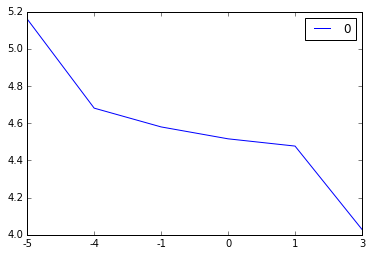

In [76]:
loop_df = pandas.DataFrame([data.mean() for data in recur_data], index=[data.name for data in recur_data])
loop_df.plot()

Additionally, number of 2-cycles decreased with adjust. Moving the start of the snake past -3 and -2 must have caused a certain pair to not be a 2-cycle.

In [19]:
cycle_data = []
for setup in varied_games:
    cycle_data.append([setup['name'][0][24:], detect_2_cycles(setup)])

cycle_df = pandas.DataFrame([data[1] for data in cycle_data], index = [data[0] for data in cycle_data])
print(cycle_df)

    0
-5  2
-4  2
-1  1
0   1
1   1
3   1


Moving the snake start up clearly negatively correlates with loopiness, which seems counterintuitive at first. But loopiness is truly the measure of how often a snake is hit; therefore, moving the snake head up causes it to be hit less. Knowing this, we can hypothesize that snakes at higher points are be hit less often. The 2-cycle data does not say much very definitively, due to its low frequency. However, there could be a correlation between 2-cycles and loopiness, as they both correlate negatively with adjustment.